In [1]:
!pip install ultralytics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 15.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 9.1 MB/s eta 0:00:00


In [2]:
import os
import cv2
import yaml
import torch
import shutil
import random
import numpy as np
from PIL import Image
import supervision as sv
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Step 1: Split the dataset into train, validation, and test sets
def load_dataset(dataset_path):
    # Identify images and labels directories
    images_dir_train = os.path.join(dataset_path, 'images/train')
    labels_dir_train = os.path.join(dataset_path, 'labels/train')
    images_dir_val = os.path.join(dataset_path, 'images/val')
    labels_dir_val = os.path.join(dataset_path, 'labels/val')
    
    # Get all image files
    train_images = [f for f in os.listdir(images_dir_train) if f.endswith(('.jpg'))]
    val_images = [f for f in os.listdir(images_dir_val) if f.endswith(('.jpg'))]
    
    # Split train into actual train (90% of train) and validation (10% of train)
    test_images, val_images = train_test_split(val_images, test_size=0.5, random_state=42)

    num_images = len(train_images) + len(val_images) + len(test_images)
    
    print(f"Train set: {len(train_images)} images ({len(train_images)/num_images*100:.1f}%)")
    print(f"Validation set: {len(val_images)} images ({len(val_images)/num_images*100:.1f}%)")
    print(f"Test set: {len(test_images)} images ({len(test_images)/num_images*100:.1f}%)")
    
    return {
        'train': [os.path.join(images_dir_train, img) for img in train_images],
        'val': [os.path.join(images_dir_val, img) for img in val_images],
        'test': [os.path.join(images_dir_val, img) for img in test_images],
        'train_labels': [os.path.join(labels_dir_train, img.replace('.jpg', '.txt')) for img in train_images],
        'val_labels': [os.path.join(labels_dir_val, img.replace('.jpg', '.txt')) for img in val_images],
        'test_labels': [os.path.join(labels_dir_val, img.replace('.jpg', '.txt')) for img in test_images]
    }

In [5]:
def organize_dataset(dataset_path, splits):
    """
    Organize the dataset into the structure required by YOLO.
    
    Args:
        dataset_path: Path to the original dataset folder
        splits: Dictionary containing the file paths for each split
    
    Returns:
        Path to the organized dataset
    """
    # Create new directory structure
    organized_dir = os.path.join('/kaggle/working/', 'datasets/organized_dataset')
    os.makedirs(organized_dir, exist_ok=True)
    
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(organized_dir, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(organized_dir, split, 'labels'), exist_ok=True)
    
    # Copy files to appropriate directories
    for split in ['train', 'val', 'test']:
        for img_path in tqdm(splits[split], desc=f"Copying {split} images"):
            img_filename = os.path.basename(img_path)
            label_filename = img_filename.replace('.jpg', '.txt')
            label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
            
            # Copy image
            shutil.copy2(
                img_path,
                os.path.join(organized_dir, split, 'images', img_filename)
            )
            shutil.copy2(
                label_path,
                os.path.join(organized_dir, split, 'labels', label_filename)
            )
    
    return organized_dir

In [6]:
def create_yaml_config(organized_dir, class_names=['class_0', 'class_1', 'class_2']):
    """
    Create a YAML configuration file for YOLO training.
    
    Args:
        organized_dir: Path to the organized dataset
        class_names: List of class names
    
    Returns:
        Path to the created YAML file
    """
    config = {
        'path': organized_dir,
        'train': os.path.join('train', 'images'),
        'val': os.path.join('val', 'images'),
        'test': os.path.join('test', 'images'),
        'nc': len(class_names),
        'names': class_names
    }
    
    yaml_path = os.path.join('datasets', organized_dir, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f)
    
    return yaml_path

In [7]:
# Train YOLO model
def train_yolo_model(yaml_path, epochs=50, batch_size=16, img_size=640):
    """
    Train a YOLO model using the ultralytics package.
    
    Args:
        yaml_path: Path to the YAML configuration file
        epochs: Number of training epochs
        batch_size: Batch size for training
        img_size: Image size for training
    
    Returns:
        Trained model
    """
    model = YOLO('yolov8n.pt')  # Load a pre-trained YOLOv8 nano model
    
    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        patience=10,  # Early stopping patience
        verbose=True,
        device='0' if torch.cuda.is_available() else 'cpu'
    )
    
    return model

In [8]:
# Function to check if validation loss has converged
def check_convergence(results, patience=5, min_delta=0.01):
    """
    Check if validation loss has converged.
    
    Args:
        results: Training results
        patience: Number of epochs to wait for improvement
        min_delta: Minimum change to qualify as an improvement
    
    Returns:
        Boolean indicating whether the loss has converged
    """
    val_losses = results.results_dict['val/box_loss']
    
    if len(val_losses) < patience + 1:
        return False
    
    # Check the last 'patience' epochs for improvement
    for i in range(1, patience + 1):
        if val_losses[-i-1] - val_losses[-i] > min_delta:
            return False  # There was improvement
    
    return True  # No significant improvement

In [9]:
dataset_path = '/kaggle/input/srip-task/dataset'
    
# Step 1: Split the dataset
splits = load_dataset(dataset_path)

Train set: 16268 images (80.0%)
Validation set: 2034 images (10.0%)
Test set: 2034 images (10.0%)


In [10]:
# Step 2: Organize the dataset for YOLO training
organized_dir = organize_dataset(dataset_path, splits)
print(organized_dir)

# Step 3: Create YAML configuration file
yaml_path = create_yaml_config("organized_dataset")

Copying train images:   0%|          | 0/16268 [00:00<?, ?it/s]

Copying val images:   0%|          | 0/2034 [00:00<?, ?it/s]

Copying test images:   0%|          | 0/2034 [00:00<?, ?it/s]

/kaggle/working/datasets/organized_dataset


In [11]:
import yaml

yaml_path = "/kaggle/working/datasets/organized_dataset/dataset.yaml"  # Update this path if needed

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

print(data)

{'names': ['class_0', 'class_1', 'class_2'], 'nc': 3, 'path': 'organized_dataset', 'test': 'test/images', 'train': 'train/images', 'val': 'val/images'}


In [12]:
import os

train_labels = "/kaggle/working/datasets/organized_dataset/train/labels"
val_labels = "/kaggle/working/datasets/organized_dataset/val/labels"

# Count the number of label files
train_label_files = os.listdir(train_labels) if os.path.exists(train_labels) else []
val_label_files = os.listdir(val_labels) if os.path.exists(val_labels) else []

print(f"Number of train label files: {len(train_label_files)}")
print(f"Number of val label files: {len(val_label_files)}")

# Show first few files if they exist
print("Sample train labels:", train_label_files[:5])
print("Sample val labels:", val_label_files[:5])

Number of train label files: 16268
Number of val label files: 2034
Sample train labels: ['train_10158.txt', 'train_12826.txt', 'train_2493.txt', 'train_13115.txt', 'train_13763.txt']
Sample val labels: ['val_807.txt', 'val_1727.txt', 'val_3897.txt', 'val_3125.txt', 'val_436.txt']


100%|██████████| 6.25M/6.25M [00:00<00:00, 87.2MB/s]


Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/datasets/organized_dataset/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/organized_dataset/train/labels... 16268 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16268/16268 [00:16<00:00, 983.35it/s] 


train: New cache created: /kaggle/working/datasets/organized_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets/organized_dataset/val/labels... 2034 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2034/2034 [00:02<00:00, 723.85it/s]

val: New cache created: /kaggle/working/datasets/organized_dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.13G      1.538      1.705      1.247        247        640: 100%|██████████| 1017/1017 [02:59<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:18<00:00,  3.40it/s]


                   all       2034      23847      0.942      0.254      0.283      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.58G      1.369      1.102       1.12        107        640: 100%|██████████| 1017/1017 [03:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.87it/s]


                   all       2034      23847      0.947      0.268      0.295      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.47G      1.354      1.018      1.114        210        640: 100%|██████████| 1017/1017 [02:59<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.88it/s]


                   all       2034      23847      0.873      0.345      0.383      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.77G      1.339     0.9478      1.112        181        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


                   all       2034      23847      0.883      0.353      0.398      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.14G      1.281     0.8524      1.086        180        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]


                   all       2034      23847      0.783      0.378      0.426      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.27G      1.239     0.8018       1.07        190        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


                   all       2034      23847      0.904        0.4      0.485      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       3.2G      1.207     0.7603      1.055        188        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


                   all       2034      23847       0.59      0.533      0.569      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.92G      1.187      0.736      1.046        158        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


                   all       2034      23847      0.793      0.585      0.669       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.56G      1.161     0.7061      1.034        130        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


                   all       2034      23847      0.786      0.702      0.764      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.76G       1.14     0.6876      1.025        182        640: 100%|██████████| 1017/1017 [02:59<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


                   all       2034      23847      0.863      0.684      0.785      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.47G      1.121     0.6677      1.017        157        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


                   all       2034      23847      0.823      0.758      0.811      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.91G       1.11     0.6576      1.012        190        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      23847      0.892      0.773       0.87        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.57G      1.091     0.6407      1.004        128        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      23847      0.908      0.801      0.874      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.45G      1.072     0.6268     0.9985        187        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


                   all       2034      23847       0.94      0.811      0.913      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.04G       1.06     0.6166     0.9926        245        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


                   all       2034      23847      0.945      0.862      0.931      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.58G      1.048     0.6061     0.9878        189        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2034      23847      0.954      0.854      0.934      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.39G      1.037     0.6002     0.9829        281        640: 100%|██████████| 1017/1017 [02:56<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


                   all       2034      23847      0.945      0.896      0.949      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.39G       1.02     0.5889     0.9794        234        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


                   all       2034      23847      0.958      0.862      0.939      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.2G      1.007     0.5789     0.9731        125        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


                   all       2034      23847      0.922      0.915      0.954      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.19G      0.997     0.5736     0.9688        182        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      23847      0.923      0.925      0.961       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.33G     0.9863     0.5648     0.9647        201        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


                   all       2034      23847      0.937      0.919       0.96      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.56G     0.9788     0.5595     0.9634        212        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      23847      0.946      0.907      0.962      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.29G     0.9706     0.5529     0.9614        171        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      23847      0.957      0.943      0.971      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.62G     0.9615     0.5494     0.9561        307        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      23847      0.959      0.929      0.969      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.13G     0.9518     0.5426      0.952        188        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]

                   all       2034      23847      0.957      0.929      0.971      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.51G      0.948     0.5401      0.952        201        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      23847      0.972      0.935      0.976      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.27G     0.9379     0.5336     0.9477        216        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]

                   all       2034      23847      0.962      0.938      0.974      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.8G     0.9301      0.528     0.9455        189        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.34it/s]

                   all       2034      23847      0.976      0.934      0.977      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.54G     0.9224     0.5233     0.9428        180        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


                   all       2034      23847      0.979      0.939      0.978      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.19G     0.9158     0.5186     0.9398        224        640: 100%|██████████| 1017/1017 [02:56<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.34it/s]


                   all       2034      23847      0.971      0.944      0.976      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.75G     0.9074     0.5127     0.9362        163        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.34it/s]


                   all       2034      23847      0.977      0.945       0.98      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.41G     0.9051     0.5115     0.9358        261        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      23847      0.973      0.952      0.982      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.18G     0.8927     0.5042     0.9325        202        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]

                   all       2034      23847      0.976       0.95      0.982      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.19G     0.8902     0.5026     0.9312        145        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2034      23847      0.991      0.944      0.983      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       3.1G     0.8837      0.499     0.9298        141        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.33it/s]

                   all       2034      23847      0.989      0.944      0.985      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.21G     0.8745     0.4927     0.9257        142        640: 100%|██████████| 1017/1017 [02:57<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      23847      0.974       0.95      0.984      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.62G     0.8672     0.4873      0.923        161        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.39it/s]


                   all       2034      23847       0.99      0.946      0.984      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.34G     0.8678     0.4898     0.9233        239        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


                   all       2034      23847      0.981      0.945      0.984      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.73G     0.8565     0.4825      0.921        141        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


                   all       2034      23847      0.985      0.943      0.984      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.68G      0.849     0.4783     0.9177        281        640: 100%|██████████| 1017/1017 [02:58<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


                   all       2034      23847      0.977      0.955      0.985      0.799
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.75G     0.7809     0.4263     0.8938        145        640: 100%|██████████| 1017/1017 [02:54<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.39it/s]


                   all       2034      23847      0.982      0.958      0.986      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.82G     0.7688     0.4204     0.8912        110        640: 100%|██████████| 1017/1017 [02:52<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.34it/s]

                   all       2034      23847      0.973      0.973      0.987      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.89G     0.7596     0.4148     0.8882        115        640: 100%|██████████| 1017/1017 [02:53<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.34it/s]

                   all       2034      23847      0.986      0.966      0.988      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.54G     0.7489     0.4089     0.8846        188        640: 100%|██████████| 1017/1017 [02:53<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]

                   all       2034      23847       0.98      0.963      0.987       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.95G     0.7457     0.4076     0.8836        161        640: 100%|██████████| 1017/1017 [02:53<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2034      23847      0.986      0.961      0.987      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.95G     0.7353      0.402     0.8813         88        640: 100%|██████████| 1017/1017 [02:53<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


                   all       2034      23847      0.986      0.961      0.987      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.08G     0.7274     0.3979     0.8782        166        640: 100%|██████████| 1017/1017 [02:53<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.37it/s]

                   all       2034      23847      0.982      0.964      0.987      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.07G     0.7209     0.3951     0.8763         83        640: 100%|██████████| 1017/1017 [02:53<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.39it/s]

                   all       2034      23847      0.983      0.968      0.987      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.57G     0.7121     0.3899     0.8745        134        640: 100%|██████████| 1017/1017 [02:52<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.38it/s]

                   all       2034      23847      0.977      0.968      0.988      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.63G     0.7091     0.3876     0.8734         78        640: 100%|██████████| 1017/1017 [02:53<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]

                   all       2034      23847      0.983      0.968      0.988      0.814



50 epochs completed in 2.684 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.56it/s]


                   all       2034      23847      0.983      0.968      0.987      0.815
               class_0       2022      23523      0.989      0.968      0.987      0.842
               class_1         71        105      0.969      0.962      0.983      0.848
               class_2        155        219      0.991      0.974      0.992      0.756


Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


KeyError: 'train/box_loss'

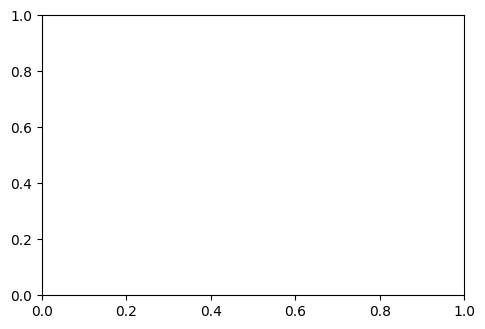

In [13]:
# Step 4: Train YOLO model
model = train_yolo_model(yaml_path, epochs=50)

# Check if validation loss has converged
if check_convergence(model.trainer):
    print("Validation loss has converged.")
else:
    print("Validation loss may not have fully converged.")

# Save the trained model
model.export(format='onnx')  # Export to ONNX format
print(f"Model saved as {os.path.join(model.trainer.save_dir, 'weights/best.pt')}")

In [26]:
for path in os.listdir("/kaggle/working/runs/detect/train/weights"):
    print(path)

last.pt
best.pt


In [27]:
best_model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
from ultralytics import YOLO
import supervision as sv
from PIL import Image
import random
from pathlib import Path

In [29]:
def load_yolo_labels(label_path, img_width, img_height):
    """
    Load YOLO format labels and convert to [x1, y1, x2, y2] format.
    
    Args:
        label_path: Path to the label file
        img_width: Width of the image
        img_height: Height of the image
    
    Returns:
        List of bounding boxes in [x1, y1, x2, y2] format and classes
    """
    if not os.path.exists(label_path):
        return [], []
    
    boxes = []
    classes = []
    
    with open(label_path, 'r') as f:
        for line in f:
            data = line.strip().split()
            if len(data) >= 5:
                cls_id = int(data[0])
                x_center = float(data[1]) * img_width
                y_center = float(data[2]) * img_height
                width = float(data[3]) * img_width
                height = float(data[4]) * img_height
                
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2
                
                boxes.append([x1, y1, x2, y2])
                classes.append(cls_id)
    
    return np.array(boxes), np.array(classes)

In [39]:
def visualize_predictions(model, test_images, test_labels, num_samples=4):
    """
    Visualize ground truth and predicted bounding boxes on random samples.
    
    Args:
        model: Trained YOLO model
        test_images: List of test image paths
        test_labels: List of test label paths
        num_samples: Number of random samples to visualize
    """
    # Select random samples from the test set
    random_indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(random_indices):
        img_path = test_images[idx]
        label_path = test_labels[idx]
        
        # Load the image
        img = Image.open(img_path)
        img_width, img_height = img.size
        img_array = np.array(img)
        
        # Load ground truth labels
        gt_boxes, gt_classes = load_yolo_labels(label_path, img_width, img_height)
        
        # Get model predictions
        results = model(img_path)
        
        # Extract predicted boxes and classes
        pred_boxes = results[0].boxes.xyxy.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy().astype(int)
        pred_scores = results[0].boxes.conf.cpu().numpy()
        
        # Plot the image
        axes[i].imshow(img_array)
        
        # Draw ground truth boxes (green)
        for box in gt_boxes:
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='green', facecolor='none')
            axes[i].add_patch(rect)
        
        # Draw predicted boxes (blue)
        for box, score in zip(pred_boxes, pred_scores):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='blue', facecolor='none')
            axes[i].add_patch(rect)
            axes[i].text(x1, y1-5, f'{score:.2f}', color='blue', fontsize=10, 
                        bbox=dict(facecolor='white', alpha=0.7))
        
        axes[i].set_title(f'Image {os.path.basename(img_path)}\nGreen: Ground Truth, Blue: Predictions')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show('prediction_visualization.png')

In [101]:
# Function to predict on multiple test images
def predict_test_set(model, test_images, test_labels):
    """
    Predict on the test set and collect results for metric calculation.
    
    Args:
        model: Trained YOLO model
        test_images: List of test image paths
        test_labels: List of test label paths
    
    Returns:
        Lists of detections and ground truths for each image
    """
    all_detections = []
    all_ground_truths = []
    
    for img_path, label_path in tqdm(zip(test_images, test_labels), total = len(test_images), desc = "Predicting: "):
        # Load the image to get dimensions
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # Get ground truth
        gt_boxes, gt_classes = load_yolo_labels(label_path, img_width, img_height)
        
        # Create supervision Detections for ground truth
        if len(gt_boxes) > 0:
            gt_detections = sv.Detections(
                xyxy=gt_boxes,
                class_id=gt_classes,
                confidence=np.ones(len(gt_boxes))  # Ground truth has 100% confidence
            )
        else:
            gt_detections = sv.Detections.empty()
        
        # Get model predictions
        results = model.predict(img_path, verbose = False)
        
        # Extract predicted boxes, classes, and scores
        pred_boxes = results[0].boxes.xyxy.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy().astype(int)
        pred_scores = results[0].boxes.conf.cpu().numpy()
        
        # Create supervision Detections for predictions
        if len(pred_boxes) > 0:
            pred_detections = sv.Detections(
                xyxy=pred_boxes,
                class_id=pred_classes,
                confidence=pred_scores
            )
        else:
            pred_detections = sv.Detections.empty()
        
        all_detections.append(pred_detections)
        all_ground_truths.append(gt_detections)

    
    
    return all_detections, all_ground_truths

In [102]:
# Main execution for prediction and visualization
def run_prediction_visualization(model_path, dataset_path, organized_dir):
    """
    Run prediction and visualization on the test set.
    
    Args:
        model_path: Path to the trained model
        dataset_path: Path to the original dataset
        organized_dir: Path to the organized dataset
    """
    # Load the trained model
    model = YOLO(model_path)
    
    # Get test images and labels
    test_img_dir = os.path.join(organized_dir, 'test', 'images')
    test_label_dir = os.path.join(organized_dir, 'test', 'labels')
    
    test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) 
                   if f.endswith(('.jpg'))]
    test_labels = [os.path.join(test_label_dir, f.replace('.jpg', '.txt')) 
                  for f in os.listdir(test_img_dir) if f.endswith(('.jpg'))]
    
    # Visualize predictions on random samples
    visualize_predictions(model, test_images, test_labels, num_samples=4)


image 1/1 /kaggle/working/datasets/organized_dataset/test/images/val_1336.jpg: 640x640 6 class_0s, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/organized_dataset/test/images/val_463.jpg: 640x640 22 class_0s, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/organized_dataset/test/images/val_3156.jpg: 640x640 6 class_0s, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/datasets/organized_dataset/test/images/val_359.jpg: 640x640 5 class_0s, 2 class_1s, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


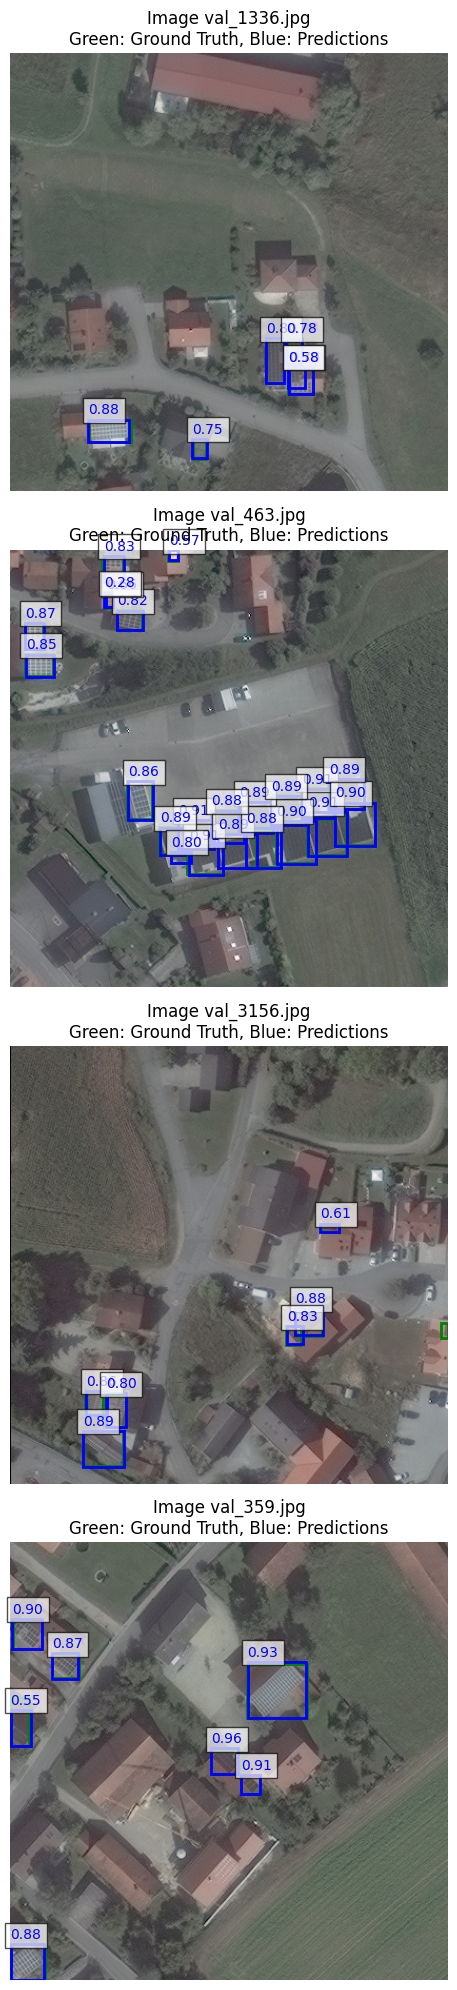

In [103]:
dataset_path = 'dataset'
organized_dir = 'datasets/organized_dataset'
model_path = '/kaggle/working/runs/detect/train/weights/best.pt'  # Path to your best model

# Run prediction and visualization
run_prediction_visualization(model_path, dataset_path, organized_dir)

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from ultralytics import YOLO
import supervision as sv
import os
from PIL import Image
from pathlib import Path
from supervision.metrics import MeanAveragePrecision
from supervision.metrics.detection import ConfusionMatrix

In [126]:
# Custom implementation of mAP50
def compute_custom_map50(detections, ground_truths, iou_threshold=0.5):
    """
    Compute mAP50 using a custom implementation.
    
    Args:
        detections: List of supervision Detections objects for predictions
        ground_truths: List of supervision Detections objects for ground truths
        iou_threshold: IoU threshold for considering a detection as correct
    
    Returns:
        mAP50 value
    """
    if len(detections) != len(ground_truths):
        raise ValueError("Detections and ground truths must have the same length")
    
    # We'll focus on calculating average precision for class 0 (solar panel)
    class_id = 0
    
    # Collect all predictions across all images with their confidences
    all_confidences = []
    all_tp = []  # True positives
    all_fp = []  # False positives
    
    total_gt = 0  # Total ground truth boxes
    
    for i in range(len(detections)):
        pred_detections = detections[i]
        gt_detections = ground_truths[i]
        
        # Filter for class 0
        pred_idx = np.where(pred_detections.class_id == class_id)[0]
        gt_idx = np.where(gt_detections.class_id == class_id)[0]
        
        pred_boxes = pred_detections.xyxy[pred_idx] if len(pred_idx) > 0 else np.array([])
        pred_confidences = pred_detections.confidence[pred_idx] if len(pred_idx) > 0 else np.array([])
        gt_boxes = gt_detections.xyxy[gt_idx] if len(gt_idx) > 0 else np.array([])
        
        total_gt += len(gt_boxes)
        
        # Sort predictions by confidence
        sort_idx = np.argsort(-pred_confidences) if len(pred_confidences) > 0 else np.array([])
        pred_boxes = pred_boxes[sort_idx] if len(sort_idx) > 0 else pred_boxes
        pred_confidences = pred_confidences[sort_idx] if len(sort_idx) > 0 else pred_confidences
        
        # Initialize arrays for true and false positives
        tp = np.zeros(len(pred_boxes))
        fp = np.zeros(len(pred_boxes))
        
        # Mark ground truth boxes as not matched yet
        gt_matched = np.zeros(len(gt_boxes), dtype=bool)
        
        # For each prediction
        for j in range(len(pred_boxes)):
            if len(gt_boxes) == 0:
                # No ground truth, all predictions are false positives
                fp[j] = 1
                continue
            
            # Calculate IoU with all ground truth boxes
            ious = sv.box_iou(
                np.expand_dims(pred_boxes[j], axis=0),
                gt_boxes
            )[0]
            
            # Get the best matching ground truth box
            best_iou_idx = np.argmax(ious)
            best_iou = ious[best_iou_idx]
            
            # If IoU is above threshold and ground truth not matched yet
            if best_iou >= iou_threshold and not gt_matched[best_iou_idx]:
                tp[j] = 1
                gt_matched[best_iou_idx] = True
            else:
                fp[j] = 1
        
        # Collect results for this image
        all_confidences.extend(pred_confidences)
        all_tp.extend(tp)
        all_fp.extend(fp)
    
    # Convert to numpy arrays
    all_confidences = np.array(all_confidences)
    all_tp = np.array(all_tp)
    all_fp = np.array(all_fp)
    
    # If no predictions or no ground truths, return 0
    if len(all_confidences) == 0 or total_gt == 0:
        return 0.0
    
    # Sort by confidence
    sort_idx = np.argsort(-all_confidences)
    all_tp = all_tp[sort_idx]
    all_fp = all_fp[sort_idx]
    
    # Compute cumulative true positives and false positives
    cum_tp = np.cumsum(all_tp)
    cum_fp = np.cumsum(all_fp)
    
    # Compute precision and recall
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / total_gt if total_gt > 0 else np.zeros_like(cum_tp)
    
    # Compute average precision
    # - Interpolate precision at 11 recall points [0, 0.1, 0.2, ..., 1.0]
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11
    
    return ap

In [137]:
def calculate_box_iou(boxes1, boxes2):
    """
    Calculate IoU between two sets of boxes
    
    Args:
        boxes1: Array of shape (N, 4) in xyxy format
        boxes2: Array of shape (M, 4) in xyxy format
        
    Returns:
        IoU matrix of shape (N, M)
    """
    # Expand dimensions to allow broadcasting
    boxes1_area = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    boxes2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    
    # Calculate intersection coordinates
    left_top = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # (N, M, 2)
    right_bottom = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # (N, M, 2)
    
    # Calculate intersection area
    width_height = np.maximum(0.0, right_bottom - left_top)  # (N, M, 2)
    intersection = width_height[:, :, 0] * width_height[:, :, 1]  # (N, M)
    
    # Calculate union area
    union = boxes1_area[:, None] + boxes2_area - intersection
    
    # Calculate IoU
    iou = intersection / union
    
    return iou

In [138]:
def compute_supervision_metrics(detections, ground_truths, iou_thresholds, confidence_thresholds):
    """
    Compute precision, recall, F1-score and mAP50 using supervision library.
    
    Args:
        detections: List of supervision Detections objects for predictions
        ground_truths: List of supervision Detections objects for ground truths
        iou_thresholds: List of IoU thresholds
        confidence_thresholds: List of confidence thresholds
    
    Returns:
        Dictionary of metrics and DataFrame with results
    """
    import numpy as np
    import pandas as pd
    import supervision as sv
    from supervision.metrics import MeanAveragePrecision
    
    results = {}
    
    # Compute mAP50 using supervision according to docs
    map_metric = MeanAveragePrecision()
    
    # Process each image
    for i in range(len(detections)):
        map_metric.update(detections[i], ground_truths[i])
    
    # Compute the mAP result
    map_result = map_metric.compute()
    
    # Store the mAP50 value
    results['map50'] = map_result.map50
    
    # Create a table for precision, recall, and F1-score at different thresholds
    table_data = []
    
    for iou_threshold in iou_thresholds:
        for conf_threshold in confidence_thresholds:
            # Calculate TP, FP, FN for all images at these thresholds
            total_tp = 0
            total_fp = 0
            total_fn = 0
            
            for img_idx in range(len(detections)):
                # Filter predictions by confidence threshold
                pred_det = detections[img_idx]
                gt_det = ground_truths[img_idx]
                
                # Apply confidence threshold
                mask = pred_det.confidence >= conf_threshold
                filtered_pred = sv.Detections(
                    xyxy=pred_det.xyxy[mask] if any(mask) else np.empty((0, 4)),
                    confidence=pred_det.confidence[mask] if any(mask) else np.array([]),
                    class_id=pred_det.class_id[mask] if any(mask) else np.array([])
                )
                
                # Calculate matches between predictions and ground truth
                if len(filtered_pred.xyxy) > 0 and len(gt_det.xyxy) > 0:
                    # Calculate IoU between each prediction and ground truth box
                    ious = calculate_box_iou(filtered_pred.xyxy, gt_det.xyxy)
                    
                    # Determine matches based on IoU threshold
                    matches = ious >= iou_threshold
                    
                    # Count true positives (each prediction matched to a ground truth)
                    tp = np.sum(np.any(matches, axis=1))
                    
                    # Count false positives (predictions without matches)
                    fp = len(filtered_pred.xyxy) - tp
                    
                    # Count false negatives (ground truths without matches)
                    fn = len(gt_det.xyxy) - np.sum(np.any(matches, axis=0))
                else:
                    # If either predictions or ground truths are empty
                    tp = 0
                    fp = len(filtered_pred.xyxy)  # All predictions are false positives
                    fn = len(gt_det.xyxy)  # All ground truths are false negatives
                
                total_tp += tp
                total_fp += fp
                total_fn += fn
            
            # Calculate metrics
            precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
            recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
            
            table_data.append({
                'IoU': iou_threshold,
                'Confidence': conf_threshold,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(table_data)
    
    # Reshape for better visualization
    precision_df = df.pivot(index='IoU', columns='Confidence', values='Precision')
    recall_df = df.pivot(index='IoU', columns='Confidence', values='Recall')
    f1_df = df.pivot(index='IoU', columns='Confidence', values='F1-Score')
    
    results['precision_df'] = precision_df
    results['recall_df'] = recall_df
    results['f1_df'] = f1_df
    results['metrics_df'] = df  # Adding the original dataframe for reference
    
    return results

In [145]:
# Visualize metrics tables
def visualize_metrics_tables(results):
    """
    Visualize the precision, recall, and F1-score tables.
    
    Args:
        results: Dictionary containing the metrics results
    """
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot precision
    sns.heatmap(results['precision_df'], annot=True, cmap='Blues', fmt='.3f', ax=axes[0])
    axes[0].set_title('Precision')
    axes[0].set_xlabel('Confidence Threshold')
    axes[0].set_ylabel('IoU Threshold')
    
    # Plot recall
    sns.heatmap(results['recall_df'], annot=True, cmap='Reds', fmt='.3f', ax=axes[1])
    axes[1].set_title('Recall')
    axes[1].set_xlabel('Confidence Threshold')
    axes[1].set_ylabel('IoU Threshold')
    
    # Plot F1-score
    sns.heatmap(results['f1_df'], annot=True, cmap='Greens', fmt='.3f', ax=axes[2])
    axes[2].set_title('F1-Score')
    axes[2].set_xlabel('Confidence Threshold')
    axes[2].set_ylabel('IoU Threshold')
    
    plt.tight_layout()
    plt.show('metrics_tables.png')
    
    print(f"Metrics tables saved as 'metrics_tables.png'")

In [146]:
# Main function to run metrics evaluation
def run_metrics_evaluation(model_path, organized_dir):
    """
    Run metrics evaluation on the test set.
    
    Args:
        model_path: Path to the trained model
        organized_dir: Path to the organized dataset
    """
    # Load the trained model
    model = YOLO(model_path)
    
    # Get test images and labels
    test_img_dir = os.path.join(organized_dir, 'test', 'images')
    test_label_dir = os.path.join(organized_dir, 'test', 'labels')
    
    test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) 
                   if f.endswith(('.jpg', '.jpeg', '.png'))]
    test_labels = [os.path.join(test_label_dir, f.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')) 
                  for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Get predictions and ground truths
    all_detections, all_ground_truths = predict_test_set(model, test_images, test_labels)
    
    # Define thresholds for evaluation
    iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
    confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    # Compute metrics
    results = compute_supervision_metrics(all_detections, all_ground_truths, iou_thresholds, confidence_thresholds)
    
    # Visualize metrics tables
    visualize_metrics_tables(results)
    
    # Save results to CSV files
    results['precision_df'].to_csv('precision_table.csv')
    results['recall_df'].to_csv('recall_table.csv')
    results['f1_df'].to_csv('f1_table.csv')
    
    print("Metrics evaluation completed. Results saved to CSV files.")

Predicting:   0%|          | 0/2034 [00:00<?, ?it/s]

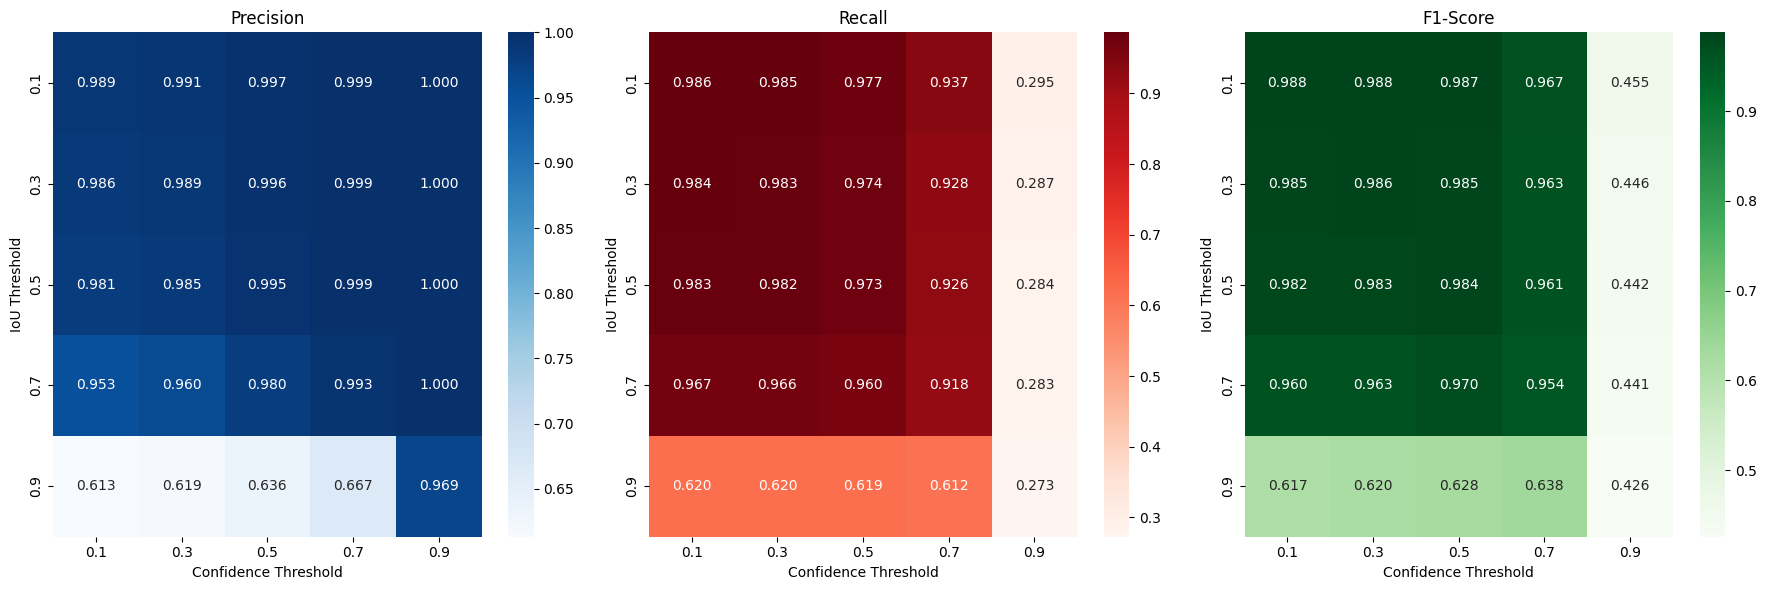

Metrics tables saved as 'metrics_tables.png'
Metrics evaluation completed. Results saved to CSV files.


In [147]:
run_metrics_evaluation(model_path, organized_dir)

In [156]:
import os
import shutil

# Specify the directory containing the files
source_dir = "/kaggle/working/runs"
zip_file_name = "runs.zip"

# Create a zip file containing all files in the directory
shutil.make_archive(base_name=zip_file_name.split('.')[0], format="zip", root_dir=source_dir)

# Check if the zip file is created
if os.path.exists(zip_file_name):
    print(f"Zip file created: {zip_file_name}")
else:
    print("Failed to create zip file.")

# Display download link
from IPython.display import FileLink
FileLink(zip_file_name)

Zip file created: runs.zip


/kaggle/working/runs.zip

In [158]:
import os

def get_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            if os.path.isfile(file_path):
                total_size += os.path.getsize(file_path)
    return total_size / (1024 * 1024)  # Convert to MB

dataset_path = "/kaggle/working"  # Change to your dataset

for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    size_mb = get_size(item_path)
    print(f"{item}: {size_mb:.2f} MB")

yolo11n.pt: 0.00 MB
yolov8n.pt: 0.00 MB
f1_table.csv: 0.00 MB
prediction_visualization.png: 0.00 MB
precision_table.csv: 0.00 MB
metrics_tables.png: 0.00 MB
runs.zip: 0.00 MB
datasets: 1386.94 MB
runs: 20.20 MB
.virtual_documents: 0.00 MB
recall_table.csv: 0.00 MB
yolo11n.onnx: 0.00 MB
